### Experimenting with lineaments / fault traces extraction from dip angle map, then calculating fault proximity and fault density attributes 

**N.B. code is optimized for Python 3.6**

##### Preliminaries - import required modules

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clr
from matplotlib.colors import ListedColormap
from skimage import color
from skimage.morphology import skeletonize, disk, square

##### Preliminaries - create Matplotlib perceptual colormap

In [2]:
# open colormap file, import raw RGB values
with open("cube1_0-1.csv", "r") as g:
  raw_data = g.read()

# split the raw data to get a list of strings
list_o_strings = raw_data.split() 

# Use a nested list comprehension to step over the list of strings, splitting each string on its commas
# and converting each element (which will still be a string) to a floating point number
list_o_lists = [[float(num) for num in string.split(',')] for string in list_o_strings]

# make a numpy array
cube1 = np.array(list_o_lists)

In [3]:
# Function to make MatplotLib colormap
def gen_cmap(name, array, start, end):
    b3 = array[:,2] # value of blue at sample n
    b2 = array[:,2] # value of blue at sample n
    b1 = np.linspace(start, end, len(b2)) # position of sample n - ranges from 0 to 1
    
    # Setting up columns for tuples
    g3 = array[:,1]
    g2 = array[:,1]
    g1 = np.linspace(start, end, len(g2))
    
    r3 = array[:,0]
    r2 = array[:,0]
    r1 = np.linspace(start, end, len(r2))
    
    # Creating tuples
    R = sorted(zip(r1,r2,r3))
    G = sorted(zip(g1,g2,g3))
    B = sorted(zip(b1,b2,b3))
    
    # Transposing
    RGB = zip(R,G,B)
    rgb = zip(*RGB)
    
    # Creating dictionary
    k = ['red', 'green', 'blue']
    Cube1 = dict(zip(k,rgb))
    
    return clr.LinearSegmentedColormap(name, Cube1)

In [4]:
my_cmap = gen_cmap('my_colormap',cube1, 1, 0)
my_cmap_r = gen_cmap('my_colormap_r', np.flipud(cube1), 1, 0)

##### Import and plot toy dataset: Penobscot horizon dip angle 

Final workflow would use discontinuity slices. 

Open-source Python discontinuity code is available from <a href="https://github.com/seg/tutorials-2015/blob/master/1512_Semblance_coherence_and_discontinuity/Discontinuity_tutorial.ipynb">Semblance, coherence, and other discontinuity attributes</a>, an SEG <a href="http://wiki.seg.org/wiki/Geophysical_tutorials"> Geophysical tutorial</a> by Joe Kington.

In [5]:
d  = np.loadtxt("Penobscot_DipAngle.txt")
d = d[50:-60,30:-30] # crop to eliminate edge effects

# nd=(d-d.min())/(d.max()-d.min()) normalized dips

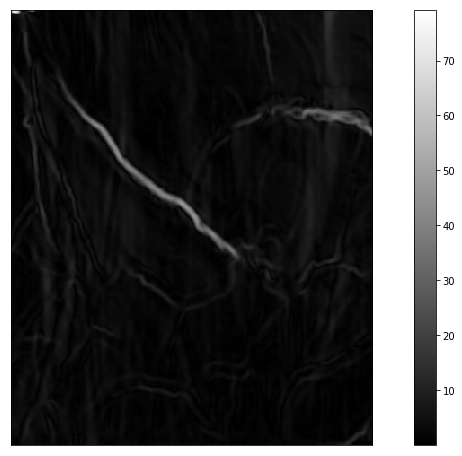

In [6]:
fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(d, cmap='gray')
plt.colorbar();

Taking a look at the distribution of dips:

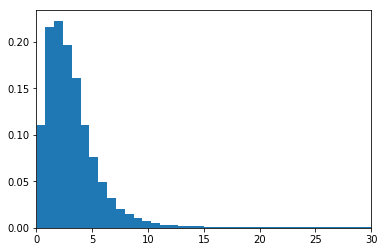

In [7]:
plt.hist(d.flatten(), 100, density=True)

axes = plt.gca()
axes.set_xlim([0,30]);

##### Eliminate small dip angles (less than 1 standar deviation from the mean value) and plot again

As suggested in:

Hart et al. (2002), 3-D seismic horizon-based approaches to fracture-swarm sweet spot definition in tight-gas reservoirs.

The Leading Edge, 21(1), 28-35.
  doi: 10.1190/1.1445844

Calculate the standard deviation and mean:

In [8]:
dstdv = d.std()
dmean = d.mean()

print (dmean, dstdv)

3.5195500306643375 3.945852580541829


Create new array with only values exceeding 1 standard deviation from the mean:

In [9]:
sd = np.zeros(d.shape)
sd[(d-dmean)>=dstdv] = d[(d-dmean)>=dstdv]

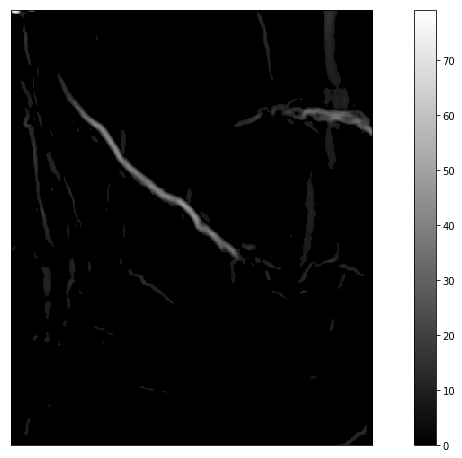

In [10]:
fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(sd, cmap='gray')
plt.colorbar();

##### Convert array to a binary image by thresholding, and clean it up prior to thinning by skeletonization

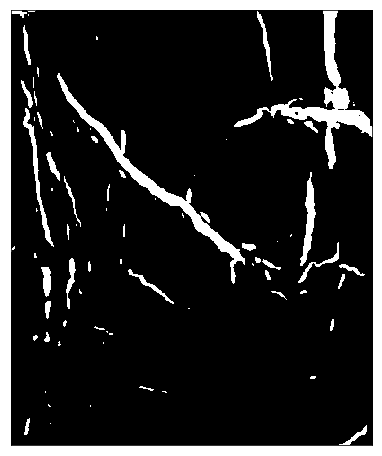

In [11]:
binary_d = color.rgb2gray(sd) > 0.1

fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(binary_d, cmap='gray');

#### NB - on cleaning up method
Cleaned it up here by removing objects smaller than a certain size (50 pixels chosen by trial and error in this case). A production workflow would involve a smarter way to eliminate 'small features'. A threshold could be difined using heuristics (based on mean size of all objects) or field analogues.

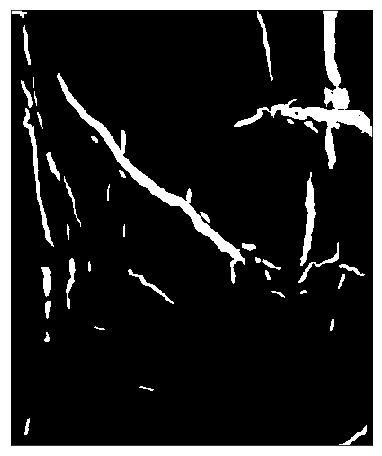

In [12]:
label_objects, nb_labels = sp.ndimage.label(binary_d)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 25
mask_sizes[0] = 0
cleaned_d = mask_sizes[label_objects]

fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(cleaned_d, cmap='gray');

##### Use skeletonization to derive thinned lineaments

In [13]:
skeleton=skeletonize(cleaned_d)

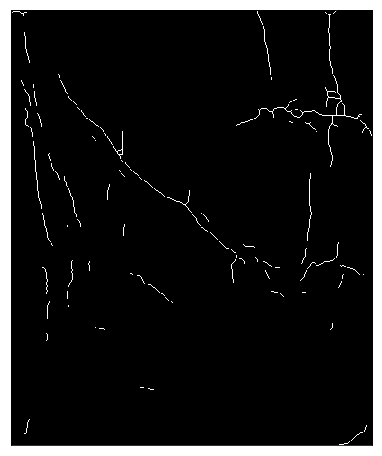

In [14]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(skeleton, cmap='gray');

##### Post-processing: work in progress. Need to merge here post processing pipeline: eliminating artifacts (minutiae) using techniques from fingerprinting analysis (spurs, lakes, bridges, etcetera)



***/ / / /*** 

##### Naive fault proximity via euclidean distance transform

Distance is expressed in pixels here. Can be converted to meters or bins.

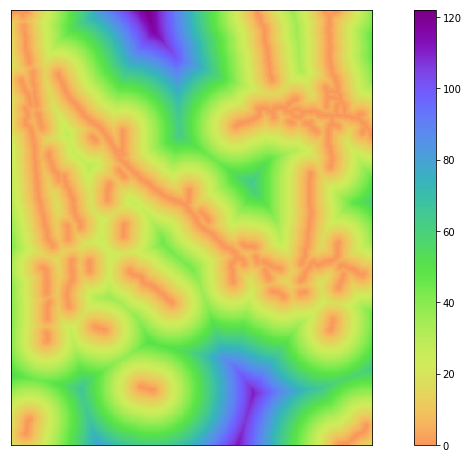

In [15]:
prxmt = (sp.ndimage.distance_transform_edt(1-skeleton))

fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(prxmt, cmap=my_cmap)
plt.colorbar();

A proximity index (normalized values, highest for locations closest to lineaments) might be more elegant, and intuitive.

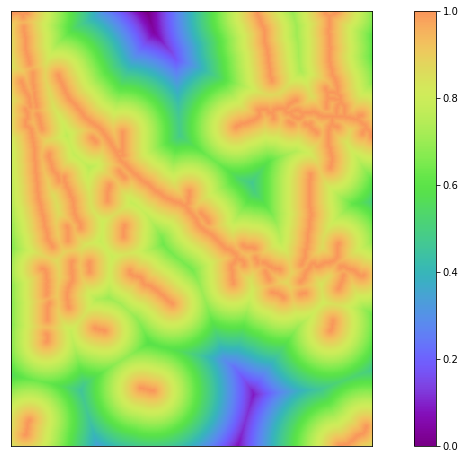

In [16]:
prxmt = np.amax(prxmt) - prxmt
prxmt=(prxmt-prxmt.min())/(prxmt.max()-prxmt.min())
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(prxmt, cmap=my_cmap_r)
plt.colorbar();

##### Naive fault density using mean-type convolutional filter

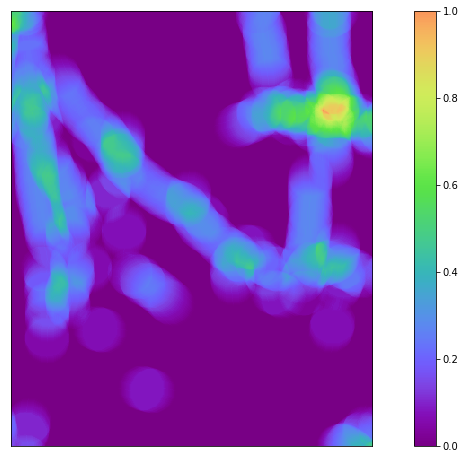

In [17]:
sem = disk(25)/25.**2
dens = sp.ndimage.convolve(skeleton.astype(np.float), sem)
dens=(dens-dens.min())/(dens.max()-dens.min())

fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(1, 1, 1)
ax.set_xticks([])
ax.set_yticks([])

plt.imshow(dens, cmap=my_cmap_r)
plt.colorbar();